In [1]:
# Rwik Rana

import numpy as np
from scipy.optimize import fsolve
from scipy.spatial.transform import Rotation 

## Utility Functions

In [2]:
def angle_wrap(angle):
    a = angle%(2*np.pi)
    if abs(a - 2*np.pi)<1e-3:
        a = 0
    return (a)

In [3]:
class DH_Calculator():
    def __init__(self,dh_params, config=['R','R']):
        # configuration of the manipulator. User has 2 choices "R"->revolute. "P"->prismatic.
        # Default configuration is a 2R manipulator with all the angles at 0 degrees and lengths being 1 unit.
        self.config = config 
        # User must input the dh parameters in matrix form i.e. "R"->revolute
        # [[a1 , alpha1 , d1, theta1]
        #  [a2 , alpha2 , d2, theta2]
        #  .
        #  .
        #  .
        #  [an , alphan , dn, thetan]]
        # n being the nth link of the manipulator.
        self.dh=dh_params
    
    def calc_tranfMatrix(self, dh_params,i):
        # Calculating Trnasformation matrix
        a, alpha,d,theta = dh_params
        A = np.array([[np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
                      [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
                      [            0,                np.sin(alpha),                np.cos(alpha),               d],
                      [            0,                            0,                            0,               1]])
        return A 

    def find_DH(self,):
        tr=self.calc_tranfMatrix(self.dh[0],0)
        Trs = [tr]
        # Calculating the individual transformation matrices. And appending to the T matrix in the following form.
        # A1
        # A1A2
        # A1A2A3 ... 
        for i in range(len(self.dh)-1):
            tr = np.matmul(tr,self.calc_tranfMatrix(self.dh[i+1],i+1))
            Trs.append(tr)

        transformation_matrix = np.array(Trs)

        return {'transformation_matrices':transformation_matrix}

# Question 1 
## Part A,B,C
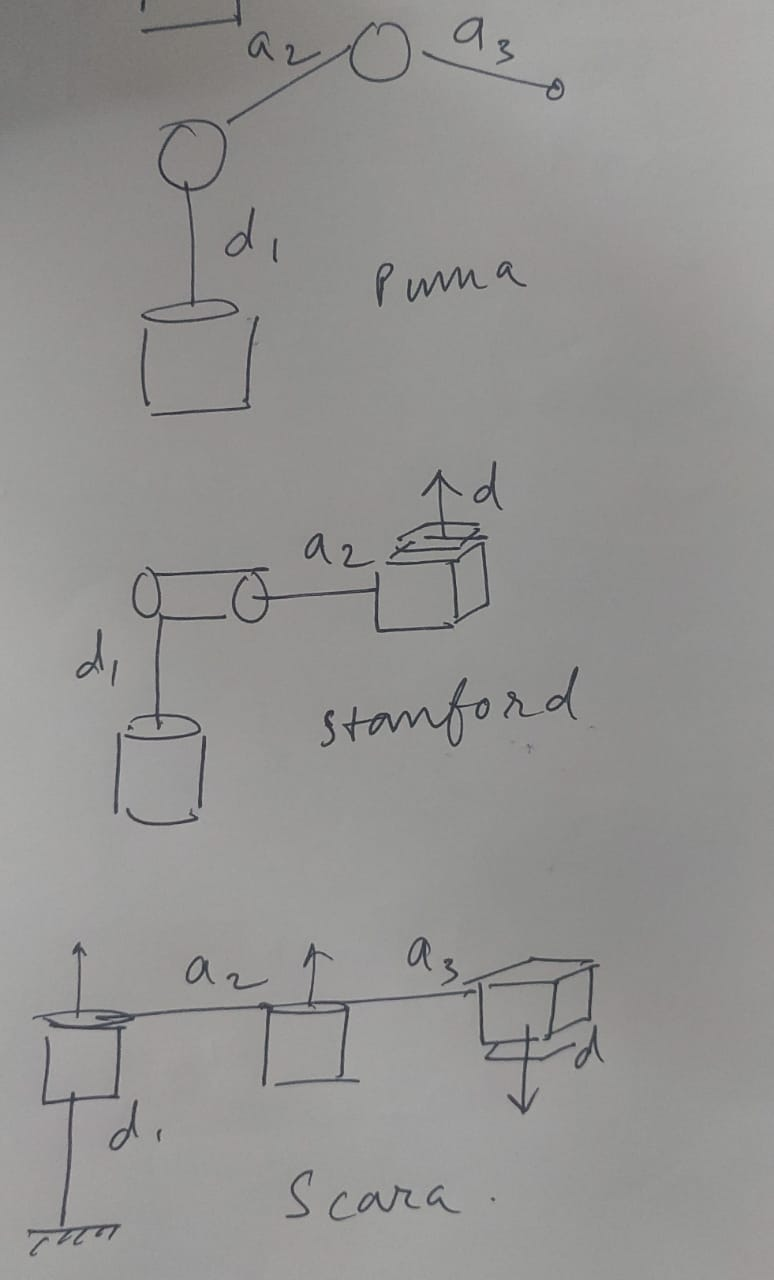
### Inverse Kinematics and workspace - PUMA

In [92]:
class PUMA():
    def __init__(self,d1=1,a2=1,a3=1):
        self.d1 = d1
        self.a2 = a2
        self.a3 = a3
    
    def inverse_kinematics(self,xc,yc,zc):

        # Workspace condition
        D = (xc**2 + yc**2 + (zc-self.d1)**2 - self.a2**2 - self.a3**2)/(2*self.a2*self.a3)
        if abs(D)<=1:
            def inv_func(x):
                return [
                        -xc + self.a2*np.cos(x[1])*np.cos(x[0]) + self.a3*np.cos(x[1]+x[2])*np.cos(x[0]),
                        -yc + self.a2*np.cos(x[1])*np.sin(x[0]) + self.a3*np.cos(x[1]+x[2])*np.sin(x[0]),
                        -zc + self.d1 + self.a2*np.sin(x[1]) + self.a3*np.sin(x[1]+x[2])
                        ]
            root = fsolve(inv_func,[0,0,0])
            q1,q2,q3 = root
            
            # Returns True if solution exists
            return True, [angle_wrap(q1),angle_wrap(q2),angle_wrap(q3)]
        else:
            # Returns True if solution exists
            print("Angles provided not in workspace")
            return False, [None, None, None]
    
    def forward_kinematics(self,q1,q2,q3):
        xc = self.a2*np.cos(q2)*np.cos(q1) + self.a3*np.cos(q2+q3)*np.cos(q1)
        yc = self.a2*np.cos(q2)*np.sin(q1) + self.a3*np.cos(q2+q3)*np.sin(q1)
        zc = self.d1 + self.a2*np.sin(q2) + self.a3*np.sin(q2+q3)

        return xc,yc,zc

In [91]:
puma = PUMA(d1 = 0.25,a2=0.25, a3 = 0.25)
xc,yc,zc = puma.forward_kinematics(0,0,0)
# Verifying
puma.inverse_kinematics(xc,yc,zc)

puma.inverse_kinematics(0.35,0.06,0.1)

(True, [0.16977827396834724, 0.2907536921734411, 4.9023290064713585])

B. All the points of the block specified can be reached by the manipulator. 
#

C. All four points specified can be reached by the joint.

### Inverse Kinematics and workspace - Stanford

In [57]:
class Stanford():
    def __init__(self,d1=1,a2=1):
        self.d1 = d1
        self.a2 = a2    
        self.max_primatic = 0.25

    def inverse_kinematics(self,xc,yc,zc):
        
        # Workspace condition
        condition = xc**2 + yc**2 + (zc**2 - self.d1)**2 - (self.a2**2 + self.max_primatic**2) <= 0 and abs(zc - self.d1)<=self.max_primatic and xc**2 + yc**2>=self.a2**2
        if condition:
      
            def inv_func(x):
                return [
                        self.a2*np.cos(x[0]) + x[2]*np.sin(x[1])*np.sin(x[0]) - xc,
                        self.a2*np.sin(x[0]) + x[2]*np.sin(x[1])*np.cos(x[0]) - yc,
                        self.d1 + x[2]*np.cos(x[1]) - zc
                        ]
            root = fsolve(inv_func,[0,0,0])

            q1,q2,d = root

            return True,[angle_wrap(q1),angle_wrap(q2),angle_wrap(d)]
        else:
            print("No Solution can be Found!")
            return False,[None, None, None]
    
    def forward_kinematics(self,q1,q2,d):

        xc = self.a2*np.cos(q1) + d*np.sin(q2)*np.sin(q1)
        yc = self.a2*np.sin(q1) + d*np.sin(q2)*np.cos(q1)
        zc = self.d1 + d*np.cos(q2)

        return xc,yc,zc

In [56]:
stan = Stanford(d1 = 0.25,a2 = 0.25)
xc,yc,zc = stan.forward_kinematics(0,0,0)

# Verifying
stan.inverse_kinematics(xc,yc,zc)

stan.inverse_kinematics(0.298,0.075,0.25)




(True, [0.19135794204043166, 1.5707963266453078, 0.018275925251502866])

B. No point on the block specified can be reached by the manipulator. The Manipulator can at max reach 0.25 in x direction. Moreover, only a small section of the points can be reached for any given link length configuration because the worspace is a sphere which has a hollow cylinder in the middle and is sliced from the top and the bottom as shown in the figure.
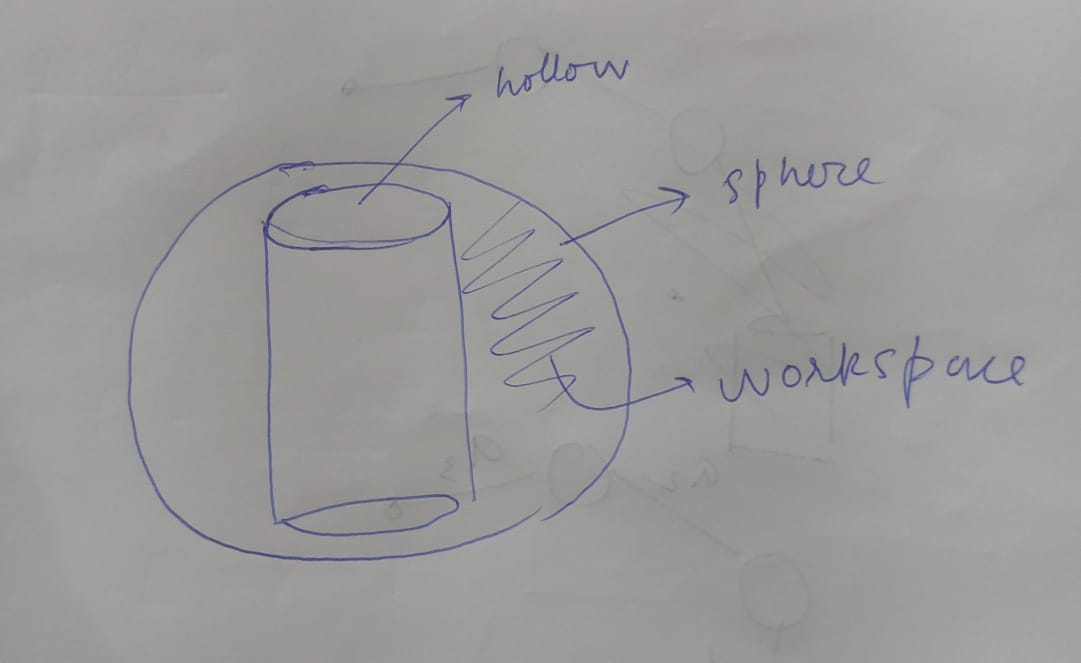

We increase the link length a2 to 0.3 to get the following results:
Points satisfying are -> (0.295,0.075,0.25),(0.295,-0.075,0.25),(0.298,0.075,0.25),(0.298,-0.075,0.25)
#

C. None of the points specified can be reached by the joint.

### Inverse Kinematics and workspace - SCARA

In [93]:
class SCARA():
    def __init__(self,d1=1,a1 = 1, a2=1):
        self.d1 = d1
        self.a1 = a1
        self.a2 = a2
        # self.a3 = a3
    

    def inverse_kinematics(self,xc,yc,zc):
        # Workspace condition
        if np.sqrt(xc**2+yc**2)>self.a2 + self.a1:
            print("No Solution can be Found!")
            return False,[None, None, None]
        else: 
            def inv_func(x):
                return [
                        - xc + self.a1*np.cos(x[0]) + self.a2*np.cos(x[0]+x[1]),
                        - yc + self.a1*np.sin(x[0]) + self.a2*np.sin(x[0]+x[1]),
                        - zc + self.d1 - x[2]
                        ]
            root = fsolve(inv_func,[1,1,1])

            q1,q2,d = root

            return True, [angle_wrap(q1),angle_wrap(q2),d]
    
    def forward_kinematics(self,q1,q2,d):

        xc = self.a1*np.cos(q1) + self.a2*np.cos(q1+q2)
        yc = self.a1*np.sin(q1) + self.a2*np.sin(q1+q2)
        zc = self.d1 - d

        return xc,yc,zc

In [60]:
scara= SCARA(d1 = 0.25,a1 = 0.25 , a2 = 0.25)
a,b,c = scara.forward_kinematics(np.pi/2,0,2)
# Verifying
_,k = scara.inverse_kinematics(a,b,c)

scara.inverse_kinematics(0.45,0.06,0.25)

(True, [5.983341884558656, 0.8647899098351919, 2.3545302577179933e-38])

B. All the points of the block specified can be reached by the manipulator. 
#

C. All four points specified can be reached by the joint.

# Question 1
## Part e,f

The main aim is to find the joint angles of the finger given the points on the plain. This case contains a spherical wrist with a tool. As the wrist is just perpendicularly above the plain, we can directly add 5cm to the desired point to get the dimensions of the spherical wrist. Next we calculate the DH parameters of the manipulator given the end effector position, taking the manipulator as a 3DOF model. Once we get the joint angles, the next step is to calculate the spherical joint angles. For this we take two vectors as shown. We find the rotation of vector 2 to vector 1 and subsquently find the euler angles for the same. Thus we get the required joint angles.

THe values given in the question can be put and checked accordingly. 
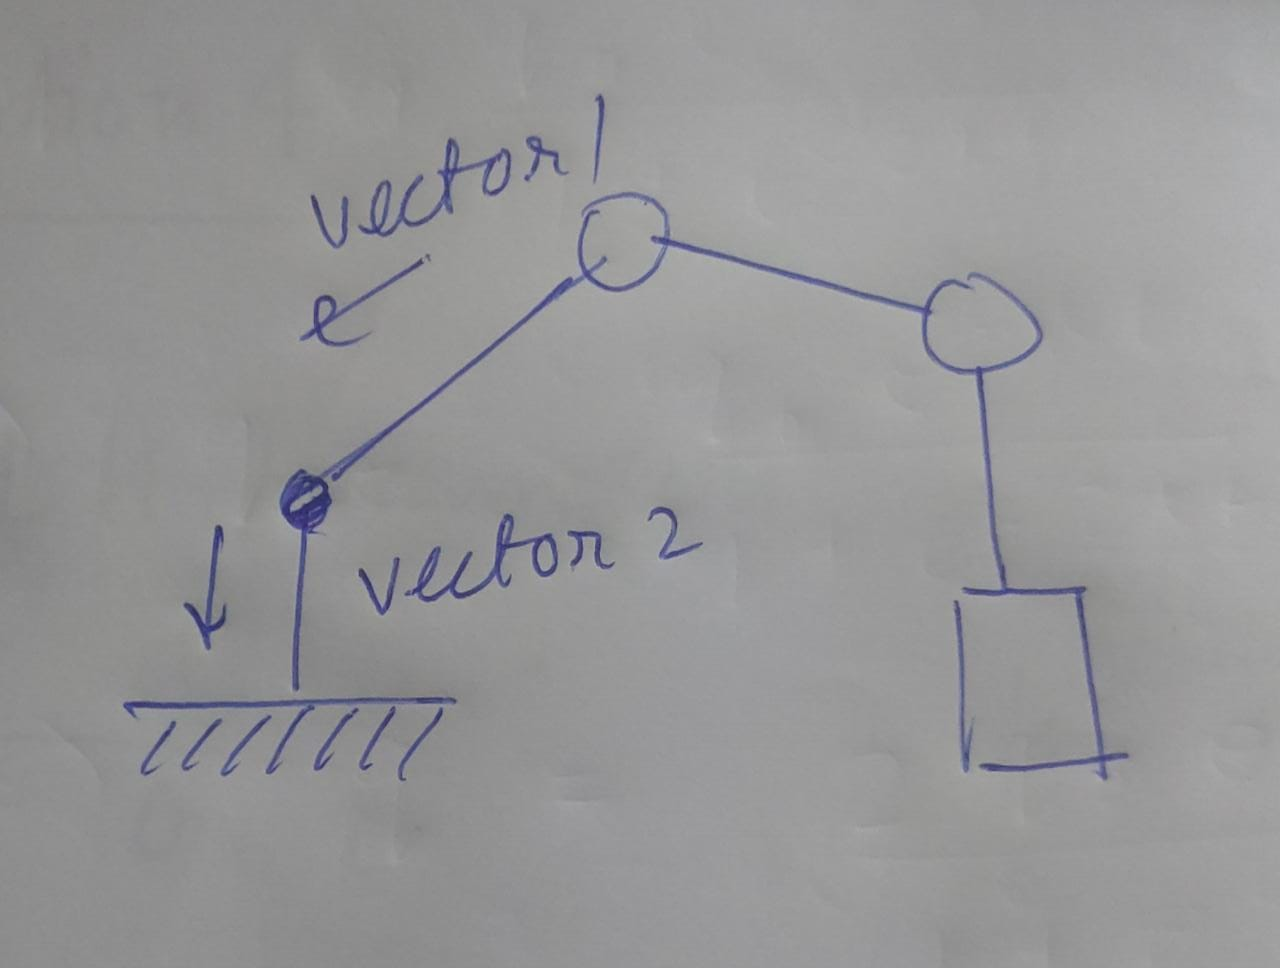


In [69]:
# https://stackoverflow.com/questions/45142959/calculate-rotation-matrix-to-align-two-vectors-in-3d-space
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [44]:
class PUMA_wrist():
    def __init__(self,d1=1,a2=1,a3=1):
        self.d1 = d1
        self.a2 = a2
        self.a3 = a3

    def inverse_kinematics_perpendicular(self,x,y,z):
        xc,yc,zc = x,y,z+0.05
        D = (xc**2 + yc**2 + (zc-self.d1)**2 - self.a2**2 - self.a3**2)/(2*self.a2*self.a3)
        if abs(D)<=1:
            def inv_func(x):
                return [
                        -xc + self.a2*np.cos(x[1])*np.cos(x[0]) + self.a3*np.cos(x[1]+x[2])*np.cos(x[0]),
                        -yc + self.a2*np.cos(x[1])*np.sin(x[0]) + self.a3*np.cos(x[1]+x[2])*np.sin(x[0]),
                        -zc + self.d1 + self.a2*np.sin(x[1]) + self.a3*np.sin(x[1]+x[2]),
                        ]
            root = fsolve(inv_func,[1,1,1])

            q1,q2,q3 = root
            q1,q2,q3 = angle_wrap(q1),angle_wrap(q2),angle_wrap(q3)
                   # print(xc,yc,zc)
            manipulator_config = ['R','R','R']
            dh_params = [[0,np.pi/2,self.d1,q1],
                        [self.a2,0,0,q2],
                        [self.a3,0,0,q3]]
            mani = DH_Calculator(dh_params,manipulator_config)
            a = mani.find_DH()
            joint_coordinates = []
            for dh_matrix in a['transformation_matrices']:
                joint_coordinates.append(dh_matrix[:3,-1])
            
            vector1 = joint_coordinates[-1] - joint_coordinates[-2]
            vector2 = [xc-x,yc-y,zc -z]

            rotation_matrix = rotation_matrix_from_vectors(vector2,vector1)
            r = Rotation.from_matrix(rotation_matrix)
            euler_angles = r.as_euler('zyx',degrees = False)
            
            joint_params = [q1,q2,q3,euler_angles[0],euler_angles[1],euler_angles[2]]

            return joint_params 
        else:
            print("No Solution can be Found!")
            return False,[None, None, None]
        # return True,[q1,q2,q3,q4,q5]
    
    def forward_kinematics(self,q1,q2,q3,q4,q5,q6):
        '''
        Example of 3R revolute manipulator
        '''
        manipulator_config = ['R','R','R','R','R','R']
        dh_params = [[0,np.pi/2,self.d1,q1],
                    [self.a2,0,0,q2],
                    [self.a3,0,0,q3],
                    [0,-np.pi/2,0,q4],
                    [0,np.pi/2,0,q5],
                    [0.05,0,0,q6]]

        mani = DH_Calculator(dh_params,manipulator_config)
        a = mani.forward_kinematics()
        print('transformation matrix')
        print(np.round(a['transformation_matrix'].astype('float'),3))
        


In [45]:
puma = PUMA_wrist(d1 = 0.25,a2=0.25, a3 = 0.25)
# puma.forward_kinematics(0,0,0,0,0,0)
puma.inverse_kinematics_perpendicular(0.45,0.075,0.25)


[3.306741334445725,
 3.440525335314134,
 5.466992691400219,
 0.15993462328647734,
 1.0301016383195338,
 -0.28129980190118786]

In [70]:
class Stanford():
    def __init__(self,d1=1,a2=1):
        self.d1 = d1
        self.a2 = a2    
        self.max_primatic = 0.25  #Maximum length of the prismatic
    def inverse_kinematics_perpendicular(self,x,y,z):
        xc,yc,zc = x,y,z+0.05
        condition = xc**2 + yc**2 + (zc**2 - self.d1)**2 - (self.a2**2 + self.max_primatic**2) <= 0 and abs(zc - self.d1)<=self.max_primatic and xc**2 + yc**2>=self.a2**2
        if condition:
      
            def inv_func(x):
                return [
                        self.a2*np.cos(x[0]) + x[2]*np.sin(x[1])*np.sin(x[0]) - xc,
                        self.a2*np.sin(x[0]) + x[2]*np.sin(x[1])*np.cos(x[0]) - yc,
                        self.d1 + x[2]*np.cos(x[1]) - zc
                        ]
            root = fsolve(inv_func,[1,1,1])

            q1,q2,d = root
            q1,q2 = angle_wrap(q1),angle_wrap(q2)
            
            manipulator_config = ['R','R','P']
            dh_params = [[0,-np.pi/2,self.d1,q1],
                        [0,np.pi/2,self.a2,q2],
                        [0,0,d,0]]
            mani = DH_Calculator(dh_params,manipulator_config)
            a = mani.find_DH()
            joint_coordinates = []
            for dh_matrix in a['transformation_matrices']:
                joint_coordinates.append(dh_matrix[:3,-1])
            
            joint_coordinates[0],joint_coordinates[1] = joint_coordinates[1],joint_coordinates[0]
            vector1 = joint_coordinates[-1] - joint_coordinates[-2]
            vector2 = [xc-x,yc-y,zc -z]

            rotation_matrix = rotation_matrix_from_vectors(vector2,vector1)
            r = Rotation.from_matrix(rotation_matrix)
            euler_angles = r.as_euler('zyx',degrees = False)
            euler_angles = [angle_wrap(i) for i in euler_angles]
            joint_params = [q1,q2,0,euler_angles[0],euler_angles[1],euler_angles[2]]

            return joint_params
        else:
            print("No Solution can be Found!")
            return False,[None, None, None,None,None]
    
    def forward_kinematics(self,q1,q2,d):
        xc = self.a2*np.cos(q1) + d*np.sin(q2)*np.sin(q1)
        yc = self.a2*np.sin(q1) + d*np.sin(q2)*np.cos(q1)
        zc = self.d1 + d*np.cos(q2)

        return xc,yc,zc

In [86]:
stan = Stanford(d1 = 0.25,a2 = 0.25)

# xc,yc,zc = stan.forward_kinematics(0.5,0,0.2)
stan.inverse_kinematics_perpendicular(0.35,0.075,0.25)

No Solution can be Found!


(False, [None, None, None, None, None])

Satisfies all the points from 0.25 to 0.3 in x direction and

The points specified in 1(c) are not satisfied



In [88]:
class SCARA_wrist():
    def __init__(self,d1=1,a1 = 1, a2=1):
        self.d1 = d1
        self.a1 = a1
        self.a2 = a2
        # self.a3 = a3
    

    def inverse_kinematics_perpendicular(self,x,y,z):
        xc,yc,zc = x,y,z+0.05
        if np.sqrt(xc**2+yc**2)>self.a2 + self.a1:
            print("No Solution can be Found!")
            return False,[None, None, None]
        else: 
            def inv_func(x):
                return [
                        - xc + self.a1*np.cos(x[0]) + self.a2*np.cos(x[0]+x[1]),
                        - yc + self.a1*np.sin(x[0]) + self.a2*np.sin(x[0]+x[1]),
                        - zc + self.d1 - x[2]
                        ]
            root = fsolve(inv_func,[1,1,1])

            q1,q2,d = root
            q1,q2 = angle_wrap(q1),angle_wrap(q2)

            joint_params = [q1,q2,0,0,0,0]

            return joint_params


    
    def forward_kinematics(self,q1,q2,d):

        xc = self.a1*np.cos(q1) + self.a2*np.cos(q1+q2)
        yc = self.a1*np.sin(q1) + self.a2*np.sin(q1+q2)
        zc = self.d1 - d

        return xc,yc,zc

In [89]:
stan = SCARA_wrist(d1 = 0.25,a1 = 0.25 , a2 = 0.25)
print(stan.inverse_kinematics_perpendicular(0.25,0.075,0.25))


[5.553057831195125, 2.043168540925235, 0, 0, 0, 0]


All the points are satisfied on the block